# Training loop draft 3 - Multiclass
J. Cristiano

This is the training loop thats gonna have all the moving parts in it:     
- Data Augmentation 
- Weighted Cross entropy loss
- Transfer learning

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import v2
from PIL import Image, ImageDraw
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
coco_root = '/work/2024_annot/images'
coco_annFile = '/work/2024_annot/2024_annotations.json'
standard_transform = transforms.v2.Compose([
    v2.CenterCrop(2048), 
    v2.Resize((512, 512)), 
    v2.ToImage()
    ])
full_dataset = datasets.CocoDetection(root=coco_root, annFile=coco_annFile, transforms=standard_transform)
full_dataset = datasets.wrap_dataset_for_transforms_v2(full_dataset, target_keys=("boxes", "labels", "masks"))

train_size = int(0.8 * len(full_dataset))
test_size = int(0.2 * len(full_dataset))
test_size += len(full_dataset) - (train_size + test_size)
full_dataset.train, full_dataset.test = torch.utils.data.random_split(full_dataset, [train_size, test_size])

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [3]:
augmentations = transforms.v2.Compose([
    transforms.v2.RandomPerspective(distortion_scale=0.25, p=0.5),
    transforms.v2.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.v2.RandomHorizontalFlip(p=0.5),
    transforms.v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    
])

def custom_collate_fn(batch):
    # Unpack the batch - assuming each item is a (image, mask) tuple
    images, masks = zip(*batch)
    mask_batch = []
    for mask in masks:
        multiclass_mask = torch.zeros((4, mask["masks"].shape[1], mask["masks"].shape[2]), dtype=mask["masks"].dtype)
        for idx, label in enumerate(mask["labels"]):
            multiclass_mask[label] = mask["masks"][idx]
        multiclass_mask[0] = 1 - torch.max(multiclass_mask[1:], dim=0)[0]
        mask_batch.append(multiclass_mask)

    return images, mask_batch

full_dataset.train.transforms = transforms.v2.Compose([standard_transform, augmentations])
train_dataloader = DataLoader(
    full_dataset.train, 
    batch_size=8, 
    shuffle=True, 
    num_workers=2,
    collate_fn=custom_collate_fn)
test_dataloader = DataLoader(
    full_dataset.test, 
    batch_size=8, 
    shuffle=True, 
    num_workers=2,
    collate_fn=custom_collate_fn)

In [4]:
# Calculate class weights for weighted cross entropy
class_counts = torch.zeros(4)
total_pixels = 0
print("Calculating class imbalances")
for _, masks in tqdm(train_dataloader):
    for mask in masks:
        for i in range(4):
            class_counts[i] += mask[i].sum()
        total_pixels += mask[0].numel()
class_weights = 1.0 / (class_counts + 1e-8)  # add small epsilon to avoid division by zero
class_weights = class_weights / class_weights.sum() * len(class_weights)  # normalize weights
print(f"Class weights: {class_weights}")

Calculating class imbalances


100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [00:07<00:00,  1.47it/s]

Class weights: tensor([0.0553, 0.8505, 1.9018, 1.1924])


In [5]:
#training loop 
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import torch.nn as nn


preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=4,                      # model output channels (number of classes in your dataset)
)
model.to(device)
criterion = nn.CrossEntropyLoss(class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
training_results = {
    "train_loss": [],
    "test_loss" : [], 
    "pocket_loss": None,
    "pocket_model": None,
}
for epoch in range(50):
    running_loss = 0.0
    for img, mask in tqdm(train_dataloader):
        model.train()
        img = torch.stack([torch.tensor(preprocess_input(i.permute(1, 2, 0).numpy())) for i in img])
        img = img.permute(0, 3, 1, 2).float()
        result = model(img.to(device))
        mask = torch.stack(mask)
        loss = criterion(result.to(device), mask.float().to(device))
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    training_results["train_loss"].append(running_loss/len(train_dataloader))
    running_loss = 0.0
    for img, mask in tqdm(test_dataloader):
        model.eval()
        img = torch.stack([torch.tensor(preprocess_input(i.permute(1, 2, 0).numpy())) for i in img])
        img = img.permute(0, 3, 1, 2).float()
        result = model(img.to(device))
        mask = torch.stack(mask)
        loss = criterion(result.to(device), mask.float().to(device))
        running_loss += loss.item()
    training_results["test_loss"].append(running_loss/len(test_dataloader))    
    
    if training_results["pocket_loss"] == None or  training_results["train_loss"][-1] < training_results["pocket_loss"]:
            training_results["pocket_loss"] = loss.item()
            training_results["pocket_model"] = model.state_dict().copy()
    print(f"Epoch {epoch} - Loss: {training_results['train_loss'][-1]}")
    print(f"Epoch {epoch} - Test Loss: {training_results['test_loss'][-1]}")



# plot([img, combined_mask])
# plot(result.squeeze().detach().cpu().numpy())


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.21it/s]


Epoch 0 - Loss: 0.1490360376509753
Epoch 0 - Test Loss: 1.4998960494995117


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.16it/s]


Epoch 1 - Loss: 0.10064394568855112
Epoch 1 - Test Loss: 3.676838477452596


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s]


Epoch 2 - Loss: 0.0690687441013076
Epoch 2 - Test Loss: 0.13263088464736938


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.14it/s]


Epoch 3 - Loss: 0.0644682567905296
Epoch 3 - Test Loss: 0.927017609278361


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.18it/s]


Epoch 4 - Loss: 0.05394898863001303
Epoch 4 - Test Loss: 0.04962850486238798


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s]


Epoch 5 - Loss: 0.04917485707185485
Epoch 5 - Test Loss: 0.045673382778962456


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.16it/s]


Epoch 6 - Loss: 0.04604382542046634
Epoch 6 - Test Loss: 0.051823741445938744


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.15it/s]


Epoch 7 - Loss: 0.03710860860618678
Epoch 7 - Test Loss: 0.04064175362388293


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.17it/s]


Epoch 8 - Loss: 0.041537472808902916
Epoch 8 - Test Loss: 0.21794541676839194


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.14it/s]


Epoch 9 - Loss: 0.05366429991342805
Epoch 9 - Test Loss: 0.36550592879454297


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 10 - Loss: 0.06253704598004167
Epoch 10 - Test Loss: 0.2635180552800496


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s]


Epoch 11 - Loss: 0.058083482425321235
Epoch 11 - Test Loss: 0.08633081863323848


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.03it/s]


Epoch 12 - Loss: 0.04896810447627848
Epoch 12 - Test Loss: 0.049964725971221924


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


Epoch 13 - Loss: 0.039211241020397705
Epoch 13 - Test Loss: 0.04143635804454485


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.17it/s]


Epoch 14 - Loss: 0.035589480603283104
Epoch 14 - Test Loss: 0.036416525642077126


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


Epoch 15 - Loss: 0.033442571251229805
Epoch 15 - Test Loss: 0.04036311184366544


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.32it/s]


Epoch 16 - Loss: 0.03332289613106034
Epoch 16 - Test Loss: 0.03565299573043982


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.14it/s]


Epoch 17 - Loss: 0.03125733916055073
Epoch 17 - Test Loss: 0.03657424387832483


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.16it/s]


Epoch 18 - Loss: 0.028645239093086937
Epoch 18 - Test Loss: 0.036533390482266746


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s]


Epoch 19 - Loss: 0.028612871569665996
Epoch 19 - Test Loss: 0.03518974160154661


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.14it/s]


Epoch 20 - Loss: 0.02825840867378495
Epoch 20 - Test Loss: 0.03965211659669876


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch 21 - Loss: 0.026923578740520912
Epoch 21 - Test Loss: 0.04782440389196078


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s]


Epoch 22 - Loss: 0.0257285073060881
Epoch 22 - Test Loss: 0.05010233819484711


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s]


Epoch 23 - Loss: 0.02515085092322393
Epoch 23 - Test Loss: 0.054789853592713676


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s]


Epoch 24 - Loss: 0.02499647590924393
Epoch 24 - Test Loss: 0.05305526281396548


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s]


Epoch 25 - Loss: 0.029869938099926167
Epoch 25 - Test Loss: 0.05065677811702093


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.32it/s]


Epoch 26 - Loss: 0.0316841241649606
Epoch 26 - Test Loss: 0.05028749257326126


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.08it/s]


Epoch 27 - Loss: 0.030849649994210762
Epoch 27 - Test Loss: 0.04827253272136053


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13it/s]


Epoch 28 - Loss: 0.027334352108565243
Epoch 28 - Test Loss: 0.04010723903775215


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s]


Epoch 29 - Loss: 0.027031535960056564
Epoch 29 - Test Loss: 0.0380567175646623


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s]


Epoch 30 - Loss: 0.029989183287728916
Epoch 30 - Test Loss: 0.040363859385252


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.05it/s]


Epoch 31 - Loss: 0.02569417418404059
Epoch 31 - Test Loss: 0.04115688117841879


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.18it/s]


Epoch 32 - Loss: 0.02615130641921
Epoch 32 - Test Loss: 0.03634601955612501


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.30it/s]


Epoch 33 - Loss: 0.02386157824234529
Epoch 33 - Test Loss: 0.036894120275974274


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s]


Epoch 34 - Loss: 0.022950752553614704
Epoch 34 - Test Loss: 0.049601033329963684


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s]


Epoch 35 - Loss: 0.02246258289299228
Epoch 35 - Test Loss: 0.04555996755758921


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s]


Epoch 36 - Loss: 0.02231205559589646
Epoch 36 - Test Loss: 0.04878020162383715


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s]


Epoch 37 - Loss: 0.023619135841727257
Epoch 37 - Test Loss: 0.042985579619805016


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13it/s]


Epoch 38 - Loss: 0.028648463839834385
Epoch 38 - Test Loss: 0.05612767611940702


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch 39 - Loss: 0.02354567735032602
Epoch 39 - Test Loss: 0.04949678232272466


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.14it/s]


Epoch 40 - Loss: 0.022883179343559525
Epoch 40 - Test Loss: 0.054297142972548805


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.34it/s]


Epoch 41 - Loss: 0.022728475488044998
Epoch 41 - Test Loss: 0.04671341242889563


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.50it/s]


Epoch 42 - Loss: 0.020437465133992107
Epoch 42 - Test Loss: 0.06213385487596194


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.16it/s]


Epoch 43 - Loss: 0.02465250122953545
Epoch 43 - Test Loss: 0.05210357904434204


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13it/s]


Epoch 44 - Loss: 0.028839982538060707
Epoch 44 - Test Loss: 0.054456779112418495


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.18it/s]


Epoch 45 - Loss: 0.028546652502634308
Epoch 45 - Test Loss: 0.03564421832561493


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch 46 - Loss: 0.02822373401034962
Epoch 46 - Test Loss: 0.04011083021759987


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch 47 - Loss: 0.023493710735982113
Epoch 47 - Test Loss: 0.03906072055300077


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s]


Epoch 48 - Loss: 0.02079752426255833
Epoch 48 - Test Loss: 0.06606340780854225


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s]

Epoch 49 - Loss: 0.018610435537993908
Epoch 49 - Test Loss: 0.07758631308873494


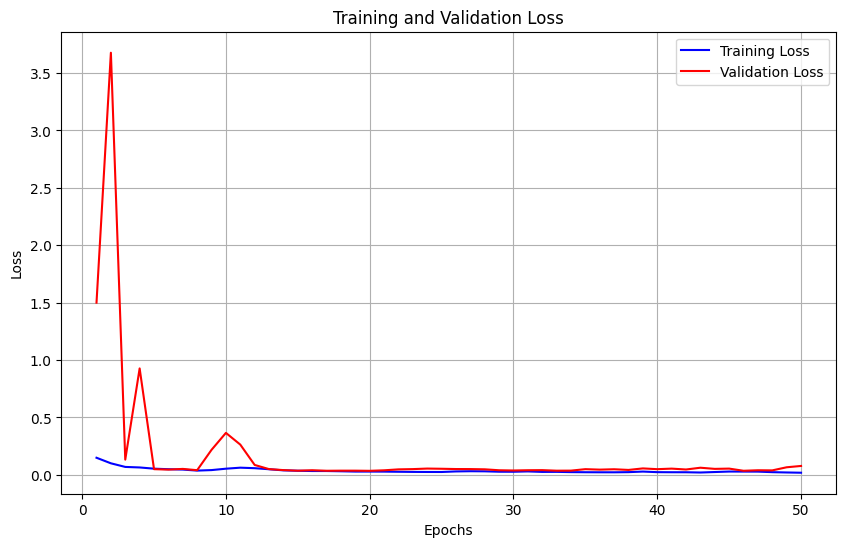

In [6]:
def plot_training_history(train_loss, test_loss, save_path=None):
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_loss) + 1)
    
    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs, test_loss, 'r-', label='Validation Loss')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    
    if save_path:
        plt.savefig(save_path)
    plt.show()
plot_training_history(training_results["train_loss"], training_results["test_loss"])

In [7]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.datasets.coco import CocoDetection

def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

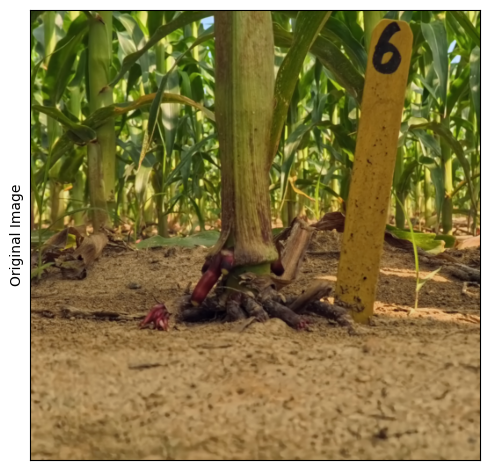

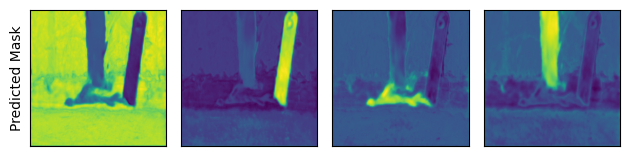

In [10]:
image, target = full_dataset.test[11]
image = torch.tensor(preprocess_input(image.permute(1, 2, 0).numpy()))
image = image.permute(2, 0, 1).unsqueeze(0).float()
result = model(image.to(device))
plot(image, row_title=["Original Image"])
plot(result.squeeze().detach().cpu().numpy(), row_title=["Predicted Mask"])

In [12]:
torch.save(model.state_dict(), '/work/multiclass_2024_UNET_sm.pth')